# Computing Work in Parallel in a DASK Task Graph

In [1]:
import numpy as np
import numba as nb
import dask
import time
import pandas as pd

In [2]:
from distributed import Client
client = Client()
client

<Client: scheduler='tcp://127.0.0.1:34128' processes=8 cores=8>

# Functions

In [3]:
def generate_square_matrix(dim):
    return np.random.rand(dim,dim)

In [4]:
def dot_np(a,b):
    return np.dot(a,b)

In [5]:
def dot_py(a,b):
    m, n = a.shape
    p = b.shape[1]
    
    c = np.zeros((m,p))

    for i in range(0,m):
        for j in range(0,p):
            for k in range(0,n):
                c[i,j] += a[i,k]*b[k,j] 
    return c

In [38]:
# dot_nb = nb.jit(nb.float64[:,:](nb.float64[:,:], nb.float64[:,:]), nopython = True)(dot_py)
dot_nb = nb.jit(nopython=True)(dot_py)
dot_nb.__name__ = 'dot_nb'

In [39]:
def timer(func, a, b):
    start = time.time()
    result = func(a, b)
    end = time.time()
    return end - start

In [48]:
dimensions = [2,10,50,100,200,500]
output = []
for dim in dimensions:
    a = dask.delayed(generate_square_matrix)(dim)
    b = dask.delayed(generate_square_matrix)(dim)
    for func in [dot_py, dot_np, dot_nb]:
        trial_times = []
        for trial in range(0,3,1):
            trial_times.append(dask.delayed(timer)(func, a, b))
        mean_time = dask.delayed(min)(trial_times)
        output.append((dim, func.__name__, mean_time))

In [49]:
def parse_times(times):
    df = pd.DataFrame(times)
    df.columns = ["dim","function","time"]
    df = df.set_index(["dim","function"]).unstack("function")
    return df

In [50]:
data = dask.delayed(parse_times)(output)

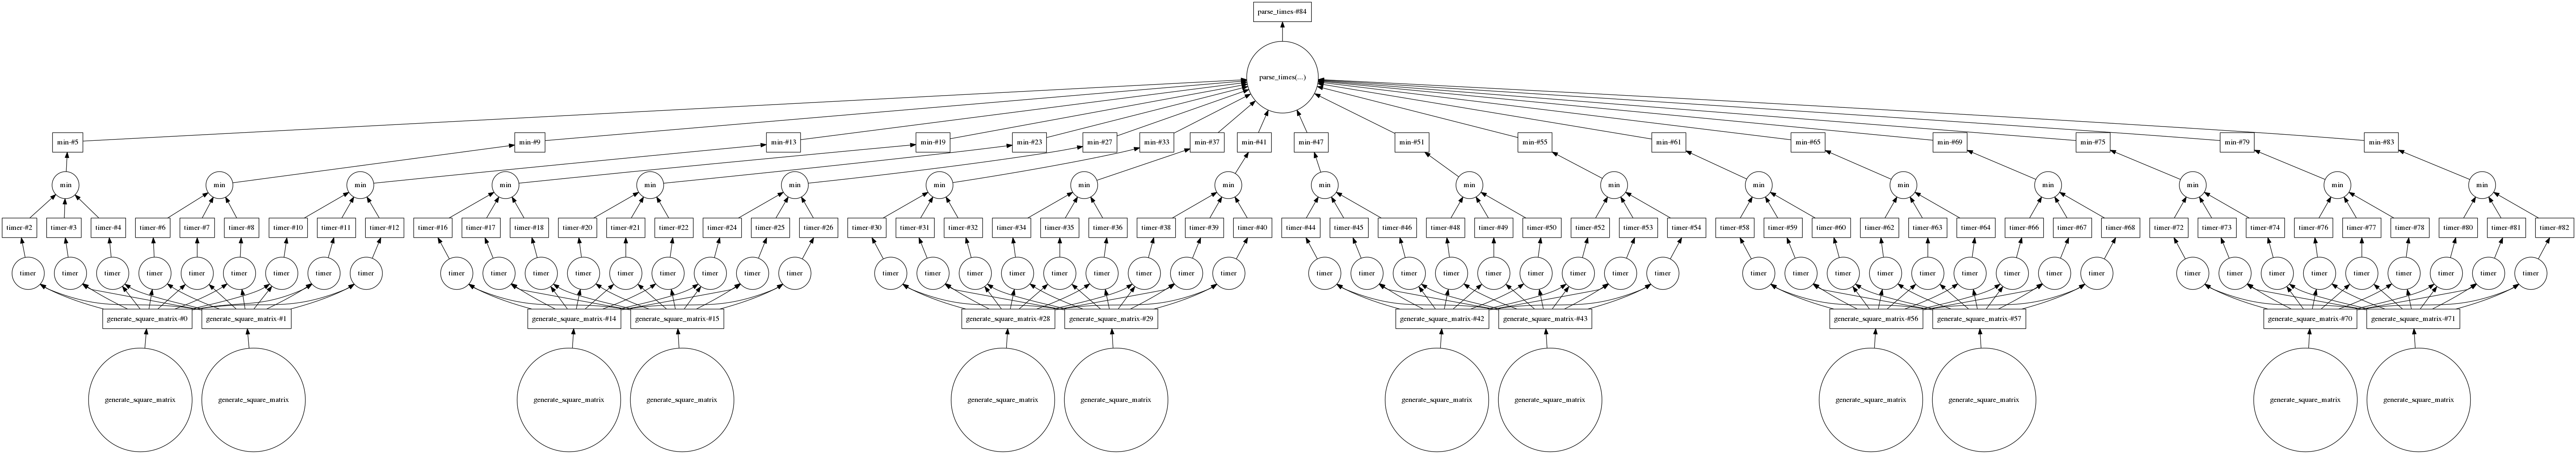

In [51]:
data.visualize()

In [52]:
data = data.compute()

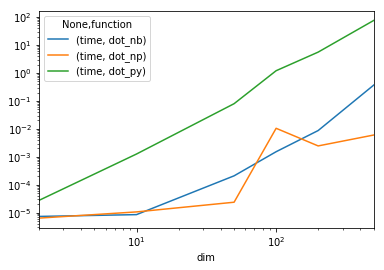

In [53]:
%matplotlib inline
data.plot(loglog=True)

# Matrix Multiplication in Parallel Using Dask and Numba